# Nexoya Challenge

In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from google.colab import drive
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# READ DATASET

performances = pd.read_csv('/content/drive/MyDrive/Nexoya/performance.csv')

## Exploratory data analysis

In [4]:
# EXPLORE DATA

performances.head(5)

,Unnamed: 0,campaign_id,campaign,metric_id,metric,provider_id,provider,timestamp,value
0,0,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-07 23:59:59,10.58
1,1,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-08 23:59:59,14.40
2,2,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-09 23:59:59,15.32
3,3,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-10 23:59:59,14.70
4,4,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-11 23:59:59,14.80


In [5]:
performances = performances.rename(columns={"Unnamed: 0": "campaign_number"})

In [6]:
# CHECK FOR INVALID DATA

performances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   campaign_number  1520 non-null   int64  
 1   campaign_id      1520 non-null   int64  
 2   campaign         1520 non-null   object 
 3   metric_id        1520 non-null   int64  
 4   metric           1520 non-null   object 
 5   provider_id      1520 non-null   int64  
 6   provider         1520 non-null   object 
 7   timestamp        1520 non-null   object 
 8   value            1520 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 107.0+ KB


In [7]:
# CHECK DIFFERENT METRICS

performances['metric'].unique()

array(['Cost', 'Impressions', 'Clicks', 'Conversions'], dtype=object)

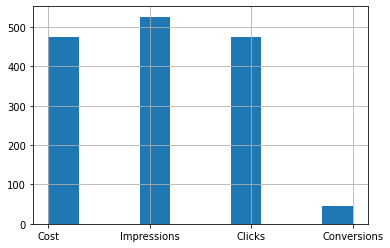

In [8]:
# CHECK DIFFERENT METRICS DISTRIBUTION

performances['metric'].hist()

In [9]:
# CHECK DIFFERENT CAMPAIGNS

performances['campaign'].unique()

array(['Car_insurance_DE_1', 'Car_insurance_DE_2', 'Car_insurance_AUT_1',
       'Car_insurance_AUT_2', 'Moto_insurance_DE_1',
       'Moto_insurance_DE_2', 'Moto_insurance_AUT_1',
       'Moto_insurance_AUT_2'], dtype=object)

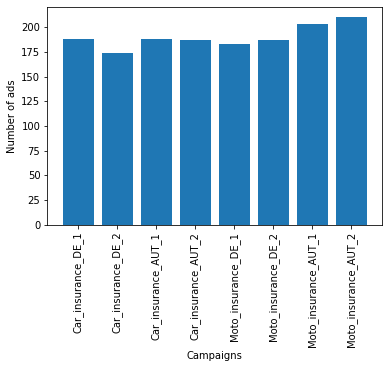

In [10]:
# CHECK DIFFERENT CAMPAIGNS DISTRIBUTION

campaigns = performances['campaign'].groupby([performances.campaign]).size()
camps = ('Car_insurance_DE_1', 
          'Car_insurance_DE_2', 
          'Car_insurance_AUT_1',
          'Car_insurance_AUT_2', 
          'Moto_insurance_DE_1',
          'Moto_insurance_DE_2', 
          'Moto_insurance_AUT_1',
          'Moto_insurance_AUT_2')

plt.bar(camps,list(campaigns.values))
plt.xticks(rotation=90)
plt.xlabel('Campaigns')
plt.ylabel('Number of ads')
plt.show()

In [11]:
# CHECK DIFFERENT PROVIDERS

performances['provider'].unique()

array(['Facebook', 'Google ads', 'Youtube'], dtype=object)

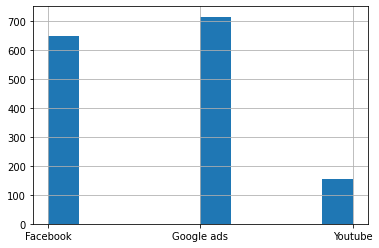

In [12]:
# CHECK DIFFERENT PROVIDERS DISTRIBUTION

performances['provider'].hist()

In [13]:
# CHECK IF ALL PROVIDERS HAVE ALL METRICS

print(len(performances.loc[(performances['metric']=='Clicks') & (performances['provider']=='Facebook')]))
print(len(performances.loc[(performances['metric']=='Clicks') & (performances['provider']=='Google ads')]))
print(len(performances.loc[(performances['metric']=='Clicks') & (performances['provider']=='Youtube')]))

216
224
35


In [14]:
print(len(performances.loc[(performances['metric']=='Impressions') & (performances['provider']=='Facebook')]))
print(len(performances.loc[(performances['metric']=='Impressions') & (performances['provider']=='Google ads')]))
print(len(performances.loc[(performances['metric']=='Impressions') & (performances['provider']=='Youtube')]))

216
224
86


In [15]:
print(len(performances.loc[(performances['metric']=='Conversions') & (performances['provider']=='Facebook')]))
print(len(performances.loc[(performances['metric']=='Conversions') & (performances['provider']=='Google ads')]))
print(len(performances.loc[(performances['metric']=='Conversions') & (performances['provider']=='Youtube')]))

0
44
0


In [16]:
# CONVERT TIMESTAMP TO RIGHT FORMAT

performances['timestamp'] = pd.to_datetime(performances['timestamp'])

In [17]:
performances['timestamp'].dt.day.unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30,  1,  2,  3,  4])

In [18]:
performances['timestamp'].dt.month.unique()

array([6, 7])

In [19]:
# ASSOCIATE DAY OF THE WEEK TO DATE

performances['week_day'] = performances['timestamp'].dt.dayofweek
performances.head()

,campaign_number,campaign_id,campaign,metric_id,metric,provider_id,provider,timestamp,value,week_day
0,0,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-07 23:59:59,10.58,1
1,1,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-08 23:59:59,14.40,2
2,2,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-09 23:59:59,15.32,3
3,3,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-10 23:59:59,14.70,4
4,4,636,Car_insurance_DE_1,0,Cost,12,Facebook,2022-06-11 23:59:59,14.80,5


In [20]:
# MAP NUMBERS TO WEEK DAYS NAMES

week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
performances['day'] = performances['week_day'].map(lambda x: week[x])

## Hans requests

### 1. Patterns

In [21]:
cost = performances.loc[performances['metric']=='Cost']

overall_cost = cost['value'].sum()
print(overall_cost)

16727.16002399847


In [22]:
clicks = performances.loc[performances['metric']=='Clicks']

overall_clicks = clicks['value'].sum()
print(overall_clicks)

45124.0


In [23]:
impressions = performances.loc[performances['metric']=='Impressions']

overall_impressions = impressions['value'].sum()
print(overall_impressions)

7490238.0


In [24]:
conversions = performances.loc[performances['metric']=='Conversions']

overall_conversions = conversions['value'].sum()
print(overall_conversions)

62.0


In [25]:
ratio_clicks = overall_clicks / overall_cost 
print("Ratio clicks/CHF:",ratio_clicks)

Ratio clicks/CHF: 2.697648610718171


In [26]:
ratio_impressions = overall_impressions / overall_cost 
print("Ratio impressions/CHF:",ratio_impressions)

Ratio impressions/CHF: 447.788984457239


In [27]:
ratio_conversions = overall_conversions / overall_cost 
print("Ratio conversions/CHF:",ratio_conversions)

Ratio conversions/CHF: 0.003706546712714445


Note: due to time constraints, I chose to show general patterns.
A more correct approach would have implied the matching of the different items costs with the corresponding amount of clicks/impressions/conversions (using merging techniques).

### 2. Platform

In [28]:
# FACEBOOK STATS

facebook = performances.loc[performances['provider']=='Facebook']
facebook_cost = facebook['value'].loc[facebook['metric']=='Cost'].sum()
facebook_clicks = facebook['value'].loc[facebook['metric']=='Clicks'].sum()
facebook_impressions = facebook['value'].loc[facebook['metric']=='Impressions'].sum()

In [29]:
print("Ratio clicks/CHF for Facebook:",facebook_clicks/facebook_cost)
print("Ratio impressions/CHF for Facebook:",facebook_impressions/facebook_cost)

Ratio clicks/CHF for Facebook: 1.3659624669708244
Ratio impressions/CHF for Facebook: 223.26925516207507


In [30]:
# GOOGLE ADS STATS

google_ads = performances.loc[performances['provider']=='Google ads']
google_ads_cost = google_ads['value'].loc[google_ads['metric']=='Cost'].sum()
google_ads_clicks = google_ads['value'].loc[google_ads['metric']=='Clicks'].sum()
google_ads_impressions = google_ads['value'].loc[google_ads['metric']=='Impressions'].sum()
google_ads_conversions = google_ads['value'].loc[google_ads['metric']=='Conversions'].sum()

In [31]:
print("Ratio clicks/CHF for Google ads:",google_ads_clicks/google_ads_cost)
print("Ratio impressions/CHF for Google ads:",google_ads_impressions/google_ads_cost)
print("Ratio conversions/CHF for Google ads:",google_ads_conversions/google_ads_cost)

Ratio clicks/CHF for Google ads: 3.004042205306951
Ratio impressions/CHF for Google ads: 499.9386026109656
Ratio conversions/CHF for Google ads: 0.004553359493668858


In [32]:
# YOUTUBE STATS

youtube = performances.loc[performances['provider']=='Youtube']
youtube_cost = youtube['value'].loc[youtube['metric']=='Cost'].sum()
youtube_clicks = youtube['value'].loc[youtube['metric']=='Clicks'].sum()
youtube_impressions = youtube['value'].loc[youtube['metric']=='Impressions'].sum()

In [33]:
print("Ratio clicks/CHF for Youtube:",youtube_clicks/youtube_cost)
print("Ratio impressions/CHF for Youtube:",youtube_impressions/youtube_cost)

Ratio clicks/CHF for Youtube: 0.896860993430412
Ratio impressions/CHF for Youtube: 36.83536223017764


### 3. Best day to launch

In [34]:
# BEST DAYS FOR NUMBER OF CLICKS

best_clicks_days = clicks['value'].groupby(clicks['day']).sum().sort_values(ascending=False)
best_clicks_days

day
Saturday     7096.0
Monday       6934.0
Sunday       6886.0
Thursday     6578.0
Friday       6428.0
Wednesday    6104.0
Tuesday      5098.0
Name: value, dtype: float64

In [35]:
# BEST DAYS FOR NUMBER OF IMPRESSIONS

best_impressions_days = impressions['value'].groupby(impressions['day']).sum().sort_values(ascending=False)
best_impressions_days

day
Monday       1197714.0
Friday       1166834.0
Thursday     1166492.0
Saturday     1083112.0
Wednesday    1060522.0
Sunday        936972.0
Tuesday       878592.0
Name: value, dtype: float64

In [36]:
# BEST DAYS FOR NUMBER OF CONVERSIONS

best_conversions_days = conversions['value'].groupby(conversions['day']).sum().sort_values(ascending=False)
best_conversions_days

day
Saturday     13.0
Sunday       11.0
Tuesday      10.0
Wednesday     9.0
Friday        8.0
Monday        7.0
Thursday      4.0
Name: value, dtype: float64

### 4. Campaign performance


#### 4.1 Plot overall performance

In [37]:
# GET COST PER DAY 

cost_day = cost['value'].groupby(cost['timestamp'].dt.date).sum().reset_index()
cost_day

,timestamp,value
0,2022-06-07,378.400003
1,2022-06-08,261.980001
2,2022-06-09,435.499996
3,2022-06-10,258.280002
4,2022-06-11,498.059997
5,2022-06-12,320.540003
6,2022-06-13,310.760000
7,2022-06-14,562.179997
8,2022-06-15,769.760001
9,2022-06-16,592.759999


In [38]:
# GET CLICKS PER DAY 

click_day = clicks['value'].groupby(clicks['timestamp'].dt.date).sum().reset_index()
click_day

,timestamp,value
0,2022-06-07,622.0
1,2022-06-08,936.0
2,2022-06-09,1338.0
3,2022-06-10,840.0
4,2022-06-11,1240.0
5,2022-06-12,1074.0
6,2022-06-13,1084.0
7,2022-06-14,1052.0
8,2022-06-15,1730.0
9,2022-06-16,1608.0


In [39]:
# GET IMPRESSIONS PER DAY 

impression_day = impressions['value'].groupby(impressions['timestamp'].dt.date).sum().reset_index()
impression_day

,timestamp,value
0,2022-06-07,146404.0
1,2022-06-08,176306.0
2,2022-06-09,263914.0
3,2022-06-10,152160.0
4,2022-06-11,218860.0
5,2022-06-12,146052.0
6,2022-06-13,181680.0
7,2022-06-14,164968.0
8,2022-06-15,280924.0
9,2022-06-16,261030.0


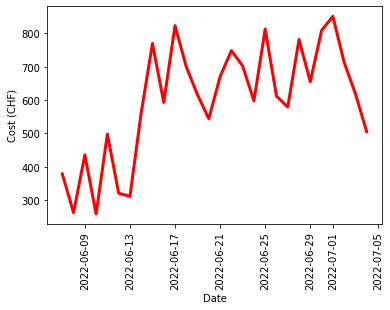

In [40]:
# PLOTTING

plt.plot(cost_day['timestamp'], cost_day['value'],'r', label='Cost', linewidth=3)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Cost (CHF)')
plt.show()

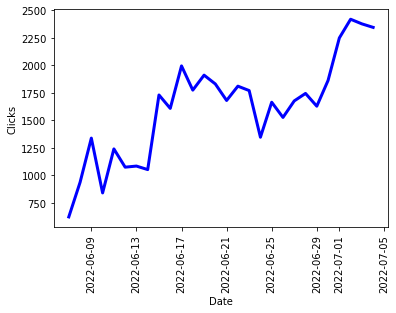

In [41]:
plt.plot(click_day['timestamp'], click_day['value'], 'b', label='clicks', linewidth=3)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.show()

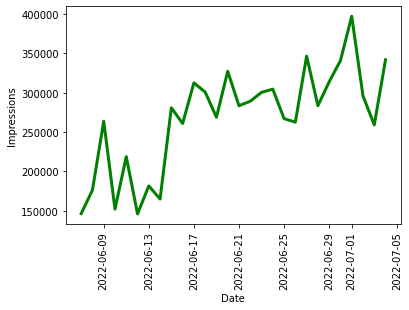

In [42]:
plt.plot(impression_day['timestamp'], impression_day['value'],'g', label='Impressions', linewidth=3)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Impressions')
plt.show()

#### 4.2 Plot campaign performance

In [43]:
colors = ('tab:blue','tab:orange','tab:green','tab:red','tab:olive','tab:purple','tab:pink','tab:cyan')

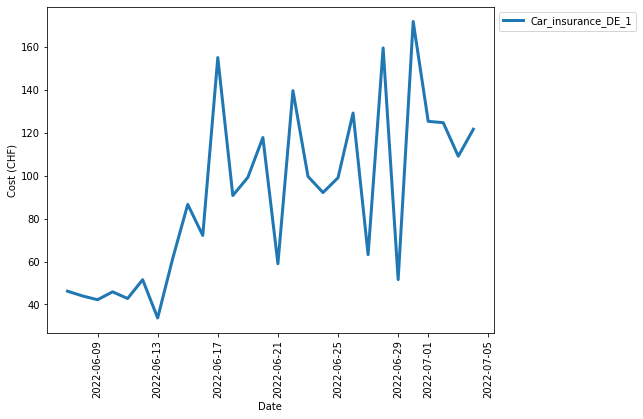

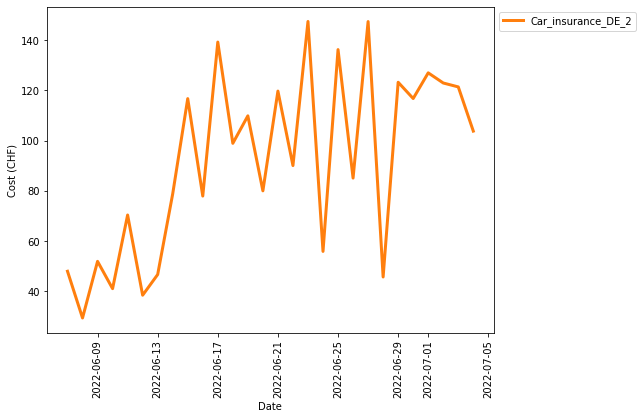

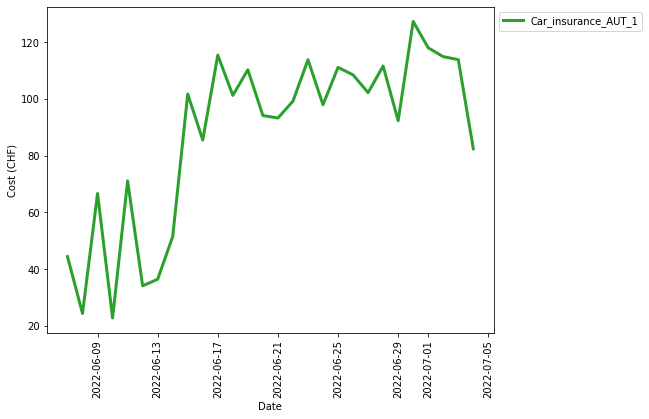

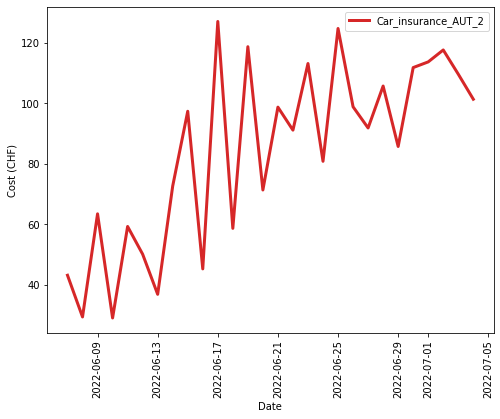

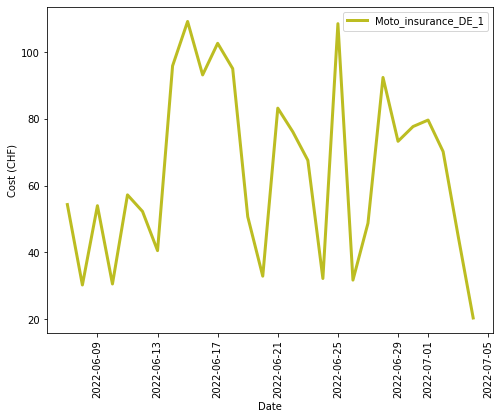

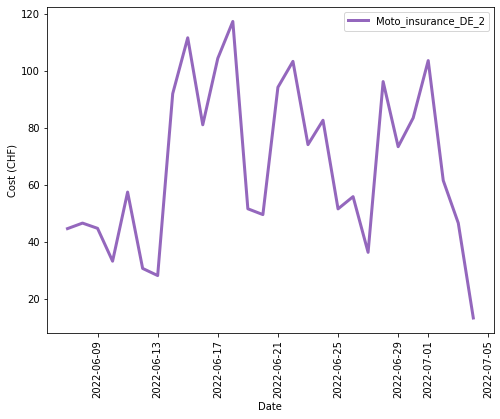

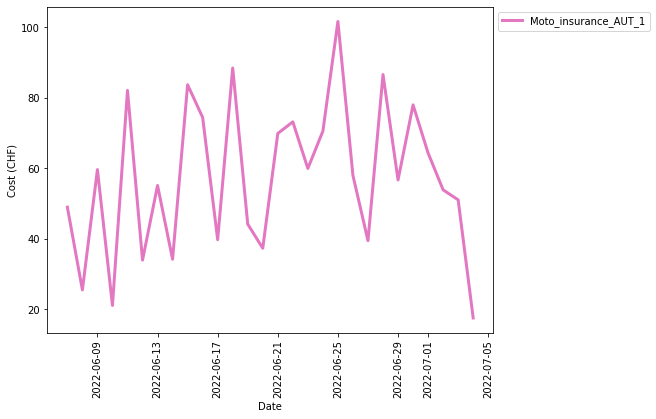

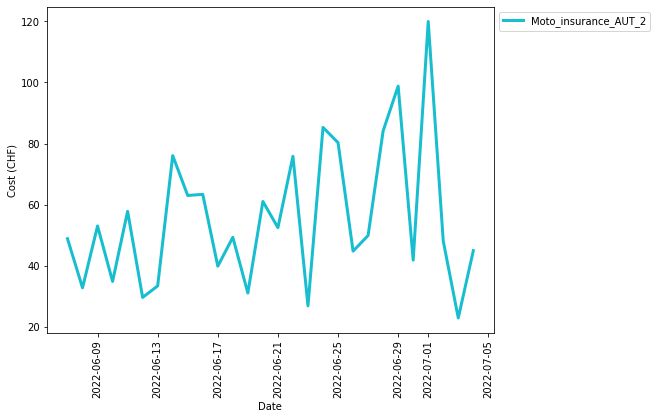

In [44]:
# PLOT DIFFERENT CAMPAIGNS COSTS

for i in range(len(camps)):
  camp = cost.loc[cost['campaign']==camps[i]]
  camp_day = camp['value'].groupby(camp['timestamp'].dt.date).sum().reset_index()
  plt.figure(figsize=(8, 6))
  plt.plot(camp_day['timestamp'], camp_day['value'], color=colors[i], label=camps[i], linewidth=3)
  plt.legend(bbox_to_anchor=(1.0, 1.0))
  plt.xticks(rotation=90)
  plt.xlabel('Date')
  plt.ylabel('Cost (CHF)')
  plt.show()

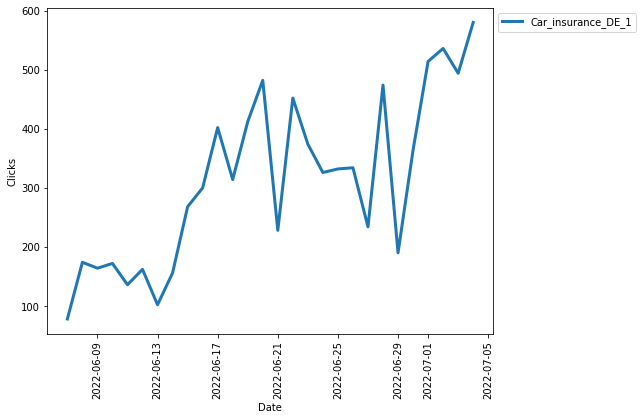

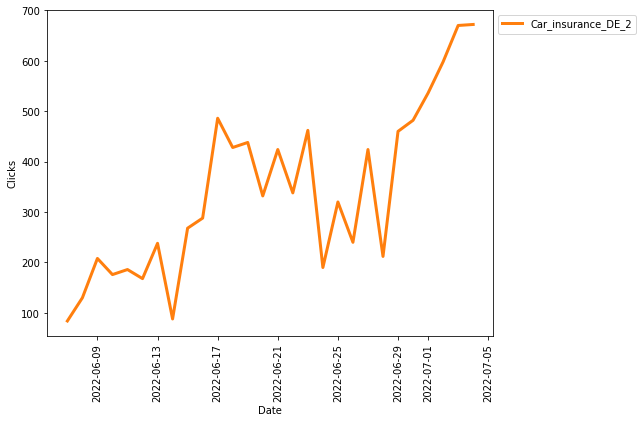

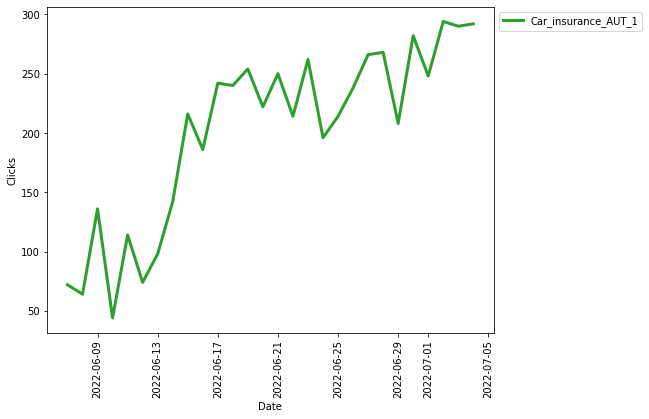

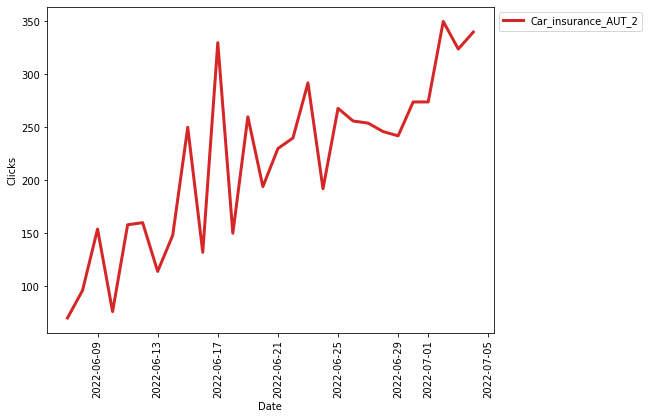

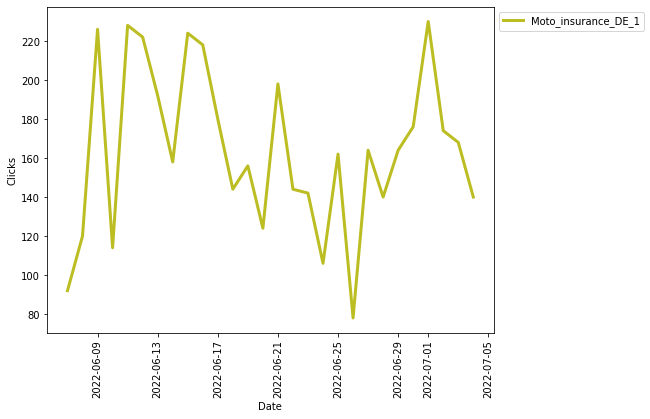

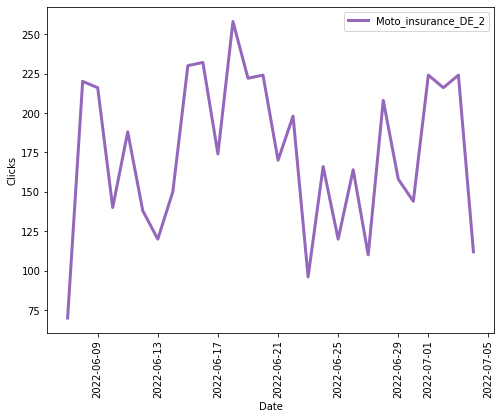

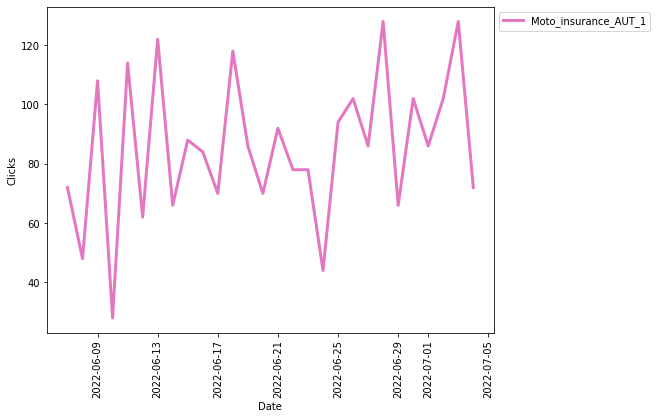

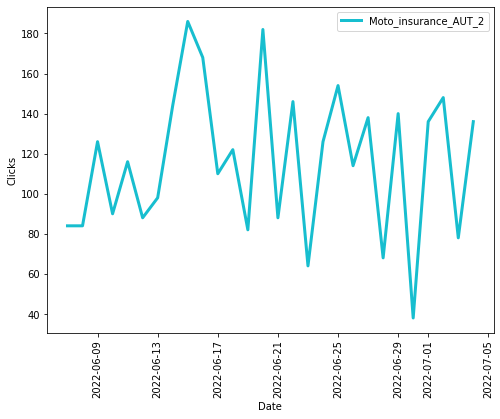

In [45]:
# PLOT DIFFERENT CAMPAIGNS CLICKS

for i in range(len(camps)):
  camp = clicks.loc[clicks['campaign']==camps[i]]
  camp_day = camp['value'].groupby(camp['timestamp'].dt.date).sum().reset_index()
  plt.figure(figsize=(8, 6))
  plt.plot(camp_day['timestamp'], camp_day['value'], color=colors[i], label=camps[i], linewidth=3)
  plt.legend(bbox_to_anchor=(1.0, 1.0))
  plt.xticks(rotation=90)
  plt.xlabel('Date')
  plt.ylabel('Clicks')
  plt.show()

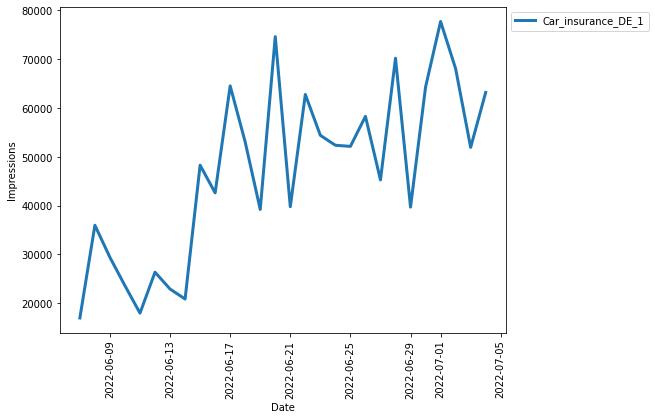

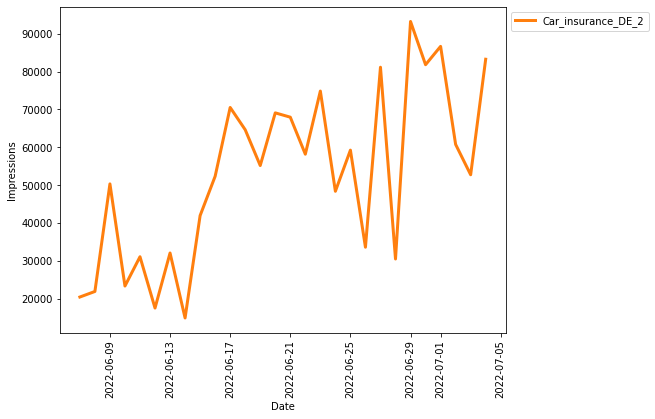

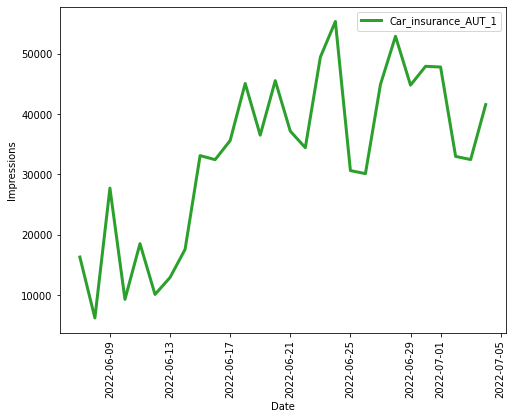

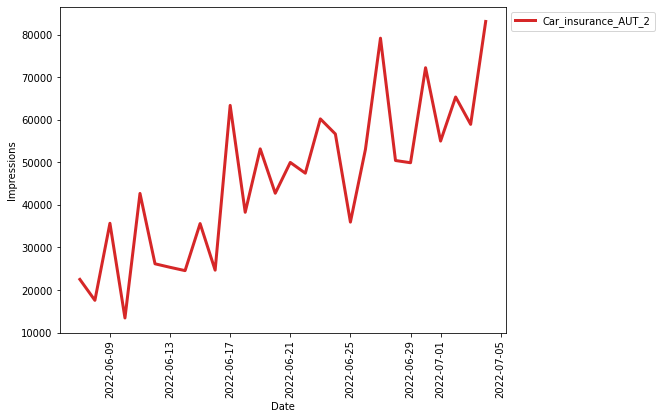

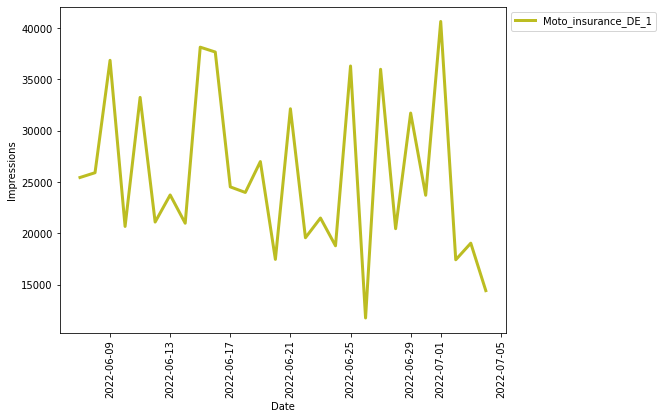

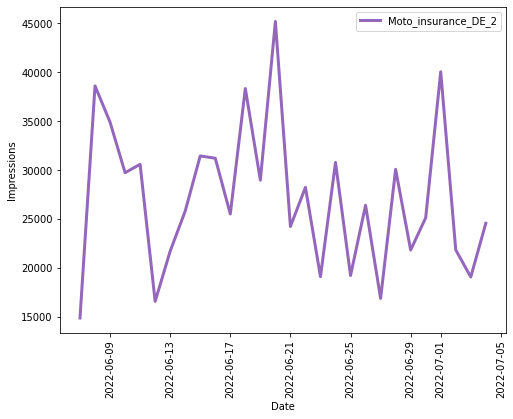

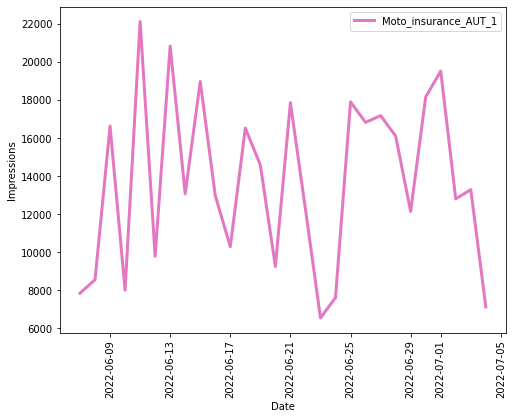

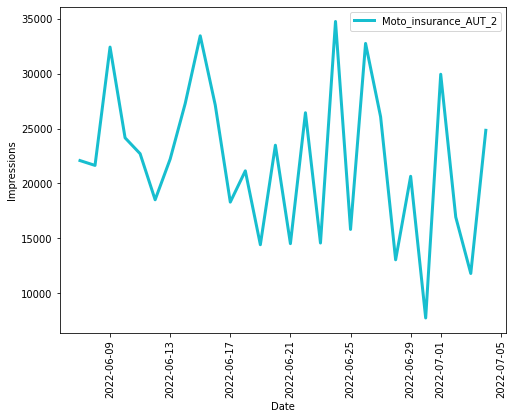

In [46]:
# PLOT DIFFERENT CAMPAIGNS IMPRESSIONS

for i in range(len(camps)):
  camp = impressions.loc[impressions['campaign']==camps[i]]
  camp_day = camp['value'].groupby(camp['timestamp'].dt.date).sum().reset_index()
  plt.figure(figsize=(8, 6))
  plt.plot(camp_day['timestamp'], camp_day['value'], color=colors[i], label=camps[i], linewidth=3)
  plt.legend(bbox_to_anchor=(1.0, 1.0))
  plt.xticks(rotation=90)
  plt.xlabel('Date')
  plt.ylabel('Impressions')
  plt.show()

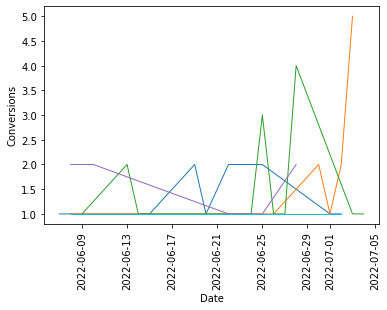

In [47]:
# PLOT DIFFERENT CAMPAIGNS CONVERSIONS 
# Note: since conversions are much more rare and some campaigns don't have them,
# we'll plot them in the same graph to save space and have a comparison

for i in range(len(camps)):
  camp = conversions.loc[conversions['campaign']==camps[i]]
  camp_day = camp['value'].groupby(camp['timestamp'].dt.date).sum().reset_index()
  plt.plot(camp_day['timestamp'], camp_day['value'], color=colors[i], label=camps[i], linewidth=1)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Conversions')
plt.show()

### 5. Forecast one campaign: let's predict impressions/CHF 

In [48]:
# LET'S FORECAST CAR INSURANCE AUT 1
# whose impressions trend looks interesting

aut_1 = performances.loc[performances['campaign']=='Car_insurance_AUT_1']
aut_1.head()

,campaign_number,campaign_id,campaign,metric_id,metric,provider_id,provider,timestamp,value,week_day,day
375,375,638,Car_insurance_AUT_1,0,Cost,12,Facebook,2022-06-07 23:59:59,10.78,1,Tuesday
376,376,638,Car_insurance_AUT_1,0,Cost,12,Facebook,2022-06-08 23:59:59,14.46,2,Wednesday
377,377,638,Car_insurance_AUT_1,0,Cost,12,Facebook,2022-06-09 23:59:59,14.90,3,Thursday
378,378,638,Car_insurance_AUT_1,0,Cost,12,Facebook,2022-06-10 23:59:59,14.68,4,Friday
379,379,638,Car_insurance_AUT_1,0,Cost,12,Facebook,2022-06-11 23:59:59,14.92,5,Saturday


In [49]:
aut_1_cost = aut_1.loc[aut_1['metric']=='Cost']
aut_1_impressions = aut_1.loc[aut_1['metric']=='Impressions']

In [50]:
aut_1_cc = aut_1_cost.merge(aut_1_impressions, how='left', on='timestamp')

In [51]:
aut_1_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   campaign_number_x  120 non-null    int64         
 1   campaign_id_x      120 non-null    int64         
 2   campaign_x         120 non-null    object        
 3   metric_id_x        120 non-null    int64         
 4   metric_x           120 non-null    object        
 5   provider_id_x      120 non-null    int64         
 6   provider_x         120 non-null    object        
 7   timestamp          120 non-null    datetime64[ns]
 8   value_x            120 non-null    float64       
 9   week_day_x         120 non-null    int64         
 10  day_x              120 non-null    object        
 11  campaign_number_y  120 non-null    int64         
 12  campaign_id_y      120 non-null    int64         
 13  campaign_y         120 non-null    object        
 14  metric_id_

In [52]:
# DROP UNWANTED COLUMNS 
# (keep only the ones that can be helpful)

aut_1_cc.drop(aut_1_cc.columns[[0, 1, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20]], axis=1, inplace=True)

In [53]:
aut_1_cc.head()

,metric_x,timestamp,value_x,metric_y,value_y
0,Cost,2022-06-07 23:59:59,10.78,Impressions,2462.0
1,Cost,2022-06-07 23:59:59,10.78,Impressions,13816.0
2,Cost,2022-06-07 23:59:59,10.78,Impressions,4.0
3,Cost,2022-06-08 23:59:59,14.46,Impressions,3506.0
4,Cost,2022-06-08 23:59:59,14.46,Impressions,2676.0


In [54]:
aut_1_cc['timestamp'] = aut_1_cc['timestamp'].dt.date

In [55]:
aut_1_cc = aut_1_cc.groupby(aut_1_cc['timestamp']).sum().reset_index()

In [56]:
# NEW METRIC (THE TARGET ONE)

aut_1_cc['value'] = aut_1_cc['value_y'] / aut_1_cc['value_x']

In [57]:
aut_1_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  28 non-null     object 
 1   value_x    28 non-null     float64
 2   value_y    28 non-null     float64
 3   value      28 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.0+ KB


In [58]:
# TEMPORAL FEATURES

aut_1_cc['timestamp'] = pd.to_datetime(aut_1_cc['timestamp'])
aut_1_cc['day'] = aut_1_cc['timestamp'].dt.day
aut_1_cc['month'] = aut_1_cc['timestamp'].dt.month
aut_1_cc['day_of_week'] = aut_1_cc['timestamp'].dt.isocalendar().day
aut_1_cc['week'] = aut_1_cc['timestamp'].dt.isocalendar().week

In [59]:
aut_1_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    28 non-null     datetime64[ns]
 1   value_x      28 non-null     float64       
 2   value_y      28 non-null     float64       
 3   value        28 non-null     float64       
 4   day          28 non-null     int64         
 5   month        28 non-null     int64         
 6   day_of_week  28 non-null     UInt32        
 7   week         28 non-null     UInt32        
dtypes: UInt32(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.7 KB


In [60]:
aut_1_cc.head(28)

,timestamp,value_x,value_y,value,day,month,day_of_week,week
0,2022-06-07,133.139996,48846.0,366.876982,7,6,2,23
1,2022-06-08,72.900000,18546.0,254.403293,8,6,3,23
2,2022-06-09,133.239999,55432.0,416.031224,9,6,4,23
3,2022-06-10,37.400001,9270.0,247.860957,10,6,5,23
4,2022-06-11,213.239997,37012.0,173.569689,11,6,6,23
5,2022-06-12,68.120000,20164.0,296.007047,12,6,7,23
6,2022-06-13,72.760001,25800.0,354.590428,13,6,1,24
7,2022-06-14,154.260001,35120.0,227.667573,14,6,2,24
8,2022-06-15,203.400004,66204.0,325.486720,15,6,3,24
9,2022-06-16,170.959999,64864.0,379.410390,16,6,4,24


In [61]:
aut_1_cc.head(28)

,timestamp,value_x,value_y,value,day,month,day_of_week,week
0,2022-06-07,133.139996,48846.0,366.876982,7,6,2,23
1,2022-06-08,72.900000,18546.0,254.403293,8,6,3,23
2,2022-06-09,133.239999,55432.0,416.031224,9,6,4,23
3,2022-06-10,37.400001,9270.0,247.860957,10,6,5,23
4,2022-06-11,213.239997,37012.0,173.569689,11,6,6,23
5,2022-06-12,68.120000,20164.0,296.007047,12,6,7,23
6,2022-06-13,72.760001,25800.0,354.590428,13,6,1,24
7,2022-06-14,154.260001,35120.0,227.667573,14,6,2,24
8,2022-06-15,203.400004,66204.0,325.486720,15,6,3,24
9,2022-06-16,170.959999,64864.0,379.410390,16,6,4,24


In [62]:
# WE'LL TRY TO PREDICT JULY 
# (last 4 entries)

train_X = aut_1_cc.head(20)
test_X = aut_1_cc.tail(8)

In [63]:
# DROP LABEL AND VALUES COLUMNS

train_y = train_X['value'].copy()
test_y = test_X['value'].copy()

timestamp_train = train_X['timestamp'].copy()
timestamp_test = test_X['timestamp'].copy()

train_X = train_X.drop(['timestamp', 'value', 'value_x','value_y'],axis=1)
test_X = test_X.drop(['timestamp', 'value', 'value_x','value_y'],axis=1)

In [64]:
train_X['day_of_week'] = train_X['day_of_week'].astype(int)
train_X['week'] = train_X['week'].astype(int)
test_X['day_of_week'] = test_X['day_of_week'].astype(int)
test_X['week'] = test_X['week'].astype(int)

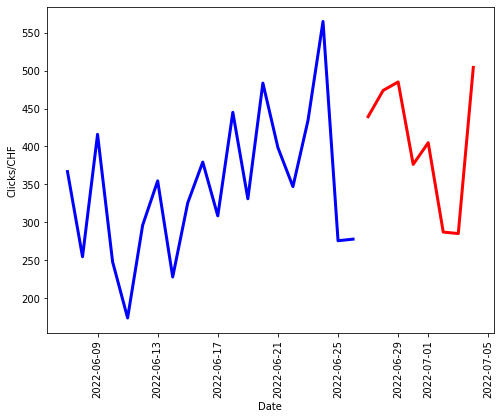

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(timestamp_train, train_y, 'b', linewidth=3)
plt.plot(timestamp_test, test_y, 'r', linewidth=3)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Impressions/CHF')
plt.show()

In [66]:
# FOR TASKS OF THIS TYPE, WE CAN USE XGBOOST
# (with params from the literature)

params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

In [67]:
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(train_X, train_y)
model = grid.best_estimator_

In [68]:
print(r2_score(test_y, model.predict(test_X)))

-0.29918591442399833


Unfortunately, the performance of the model is really poor. This might be due to the fact that the data trend in July is significantly different from the one in June, as seen in the graph, or that the label I've tried to predict is not a suitable choice.

In [69]:
# PREDICTIONS
# (we can Naively predict the new days as the mean of the 
# previous month since the model perform poorly)

new_dates = ['2022-07-05', '2022-07-06', '2022-07-07']
mean = train_y.mean()
predictions = [mean, mean, mean]

For future and deeper work, it would be necessary to explore further, try different models and predict other types of labels.